# Апробация моделей частотных сканов на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## 0. Импорт модулей

In [2]:
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from pydlts.fsmodels import SklMultiExpFrequencyScan, SklSingleExpFrequencyScan

from pydlts.fsplots import plot_experimental_points
from pydlts.fsplots import plot_spectr
from pydlts.fsplots import plot_model
from pydlts.fsplots import plot_loss_path
from pydlts.fsplots import plot_deviations

%matplotlib inline

## 1. Чтение данных

In [3]:
DATASETS_PATH = '../datasets/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [4]:
file_names = listdir(DATASETS_PATH)

### 1.1. Выберем данные полученные при $U_1 = -4$ В и $U_R = -5$ В
Данному критерию соответствуют 3 частотных скана

In [5]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASETS_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [6]:
len(data_frames)

3

Отсортируем частотные сканы по температуре в начале сканирования

In [7]:
key_func = lambda x: x[1].temperature_k.iloc[0]
data_frames.sort(key=key_func)

for i, item in enumerate(data_frames):
    print(f'{i}.', item[0])

0. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv
1. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv
2. 1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = -10^\circ C$

In [8]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [9]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +10^\circ C$

In [10]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [11]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +30^\circ C$

In [12]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 34 точки. Данные не содержат пропусков.

In [13]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_-10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 2.1. Подготовка экспериментальных данных

Чтение данных

In [14]:
print(data_frames[0][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


In [15]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    X = np.log10(dataset.frequency_hz.to_numpy())
    y = dataset.dlts_pf.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    return filling_pulse, X_train, y_train, X_test, y_test

In [16]:
filling_pulse, X_train, y_train, X_test, y_test = get_X_y(data_frames[0][1])

Выведем тренировачный набор данных

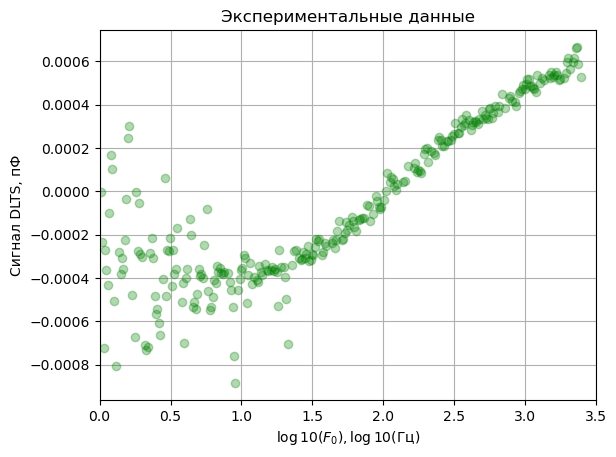

In [17]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_train_data.pdf',
            bbox_inches='tight')
plt.show()

Выведем тестовый набор данных

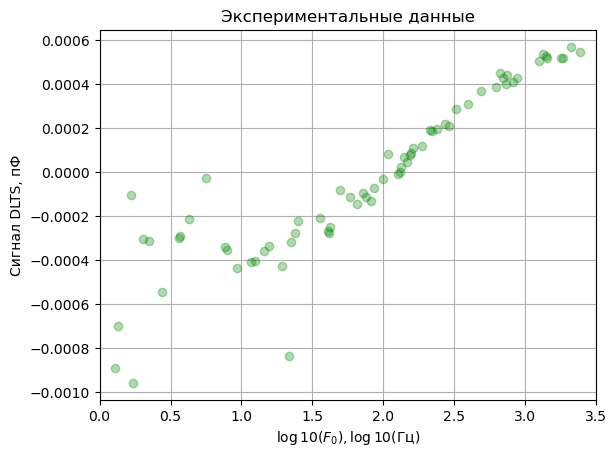

In [18]:
fig, ax = plot_experimental_points(X_test, y_test)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_test_data.pdf',
            bbox_inches='tight')
plt.show()

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$
Идентификация модели:

In [19]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-3.0, 0.5]])

2022-10-07 11:36:53.981430: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-07 11:36:53.981452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-MS-7C80
2022-10-07 11:36:53.981456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-MS-7C80
2022-10-07 11:36:53.981526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-07 11:36:53.981539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-07 11:36:53.981543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-07 11:36:53.981936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU in

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

In [20]:
monoexp_fs._exps_params

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float64, numpy=array([[-3.56646646e+00,  5.43394001e-04]])>

Вывод табличных результатов идентификации

In [21]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_fit_results_1.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
262,0.000543,0.00001,True,0.05,8.549076e-08,1,1000,0.757985,0.00001,-3.563759,False
263,0.000543,0.00001,True,0.05,8.549001e-08,1,1000,0.757559,0.00001,-3.564066,False
264,0.000543,0.00001,True,0.05,8.548927e-08,1,1000,0.757134,0.00001,-3.564371,False
265,0.000543,0.00001,True,0.05,8.548854e-08,1,1000,0.756710,0.00001,-3.564674,False
266,0.000543,0.00001,True,0.05,8.548782e-08,1,1000,0.756286,0.00001,-3.564977,False
267,0.000543,0.00001,True,0.05,8.548711e-08,1,1000,0.755864,0.00001,-3.565277,False
268,0.000543,0.00001,True,0.05,8.548641e-08,1,1000,0.755442,0.00001,-3.565577,False
269,0.000543,0.00001,True,0.05,8.548572e-08,1,1000,0.755021,0.00001,-3.565875,False
270,0.000543,0.00001,True,0.05,8.548504e-08,1,1000,0.754601,0.00001,-3.566171,False
271,0.000543,0.00001,True,0.05,8.548437e-08,1,1000,0.754181,0.00001,-3.566466,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

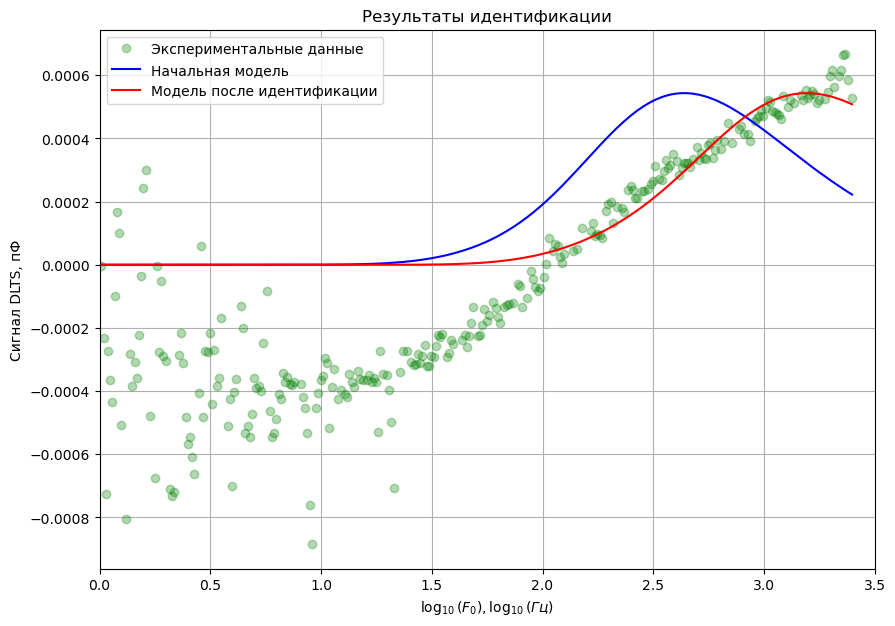

In [22]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_1.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

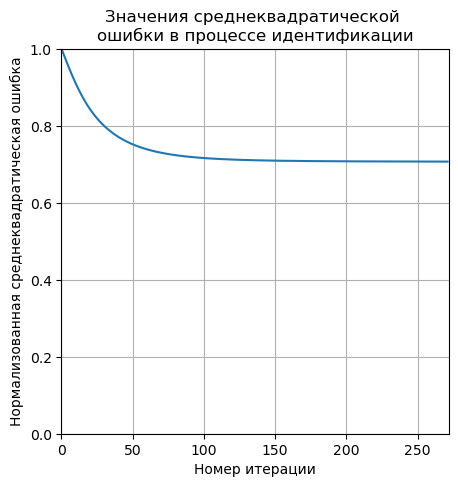

In [23]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_loss_1.pdf',
            bbox_inches='tight')
plt.show()

График выходит на "плато", что свидетельствует о том, что решение сошлось, однако довольно высокое значение среднеквадратической ошибки может указывать на то, что алгоритм нашёл локальный минимум функции потерь. О последнем также свидетельсвует предыдущий график (графика с экспериментальными данными и данными полученными на идентифицированной модели).

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

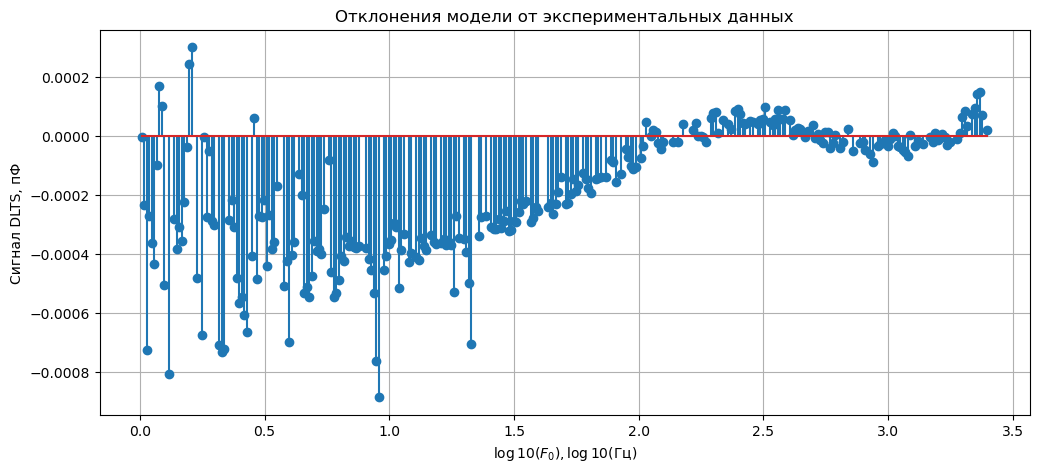

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_deviations_1.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

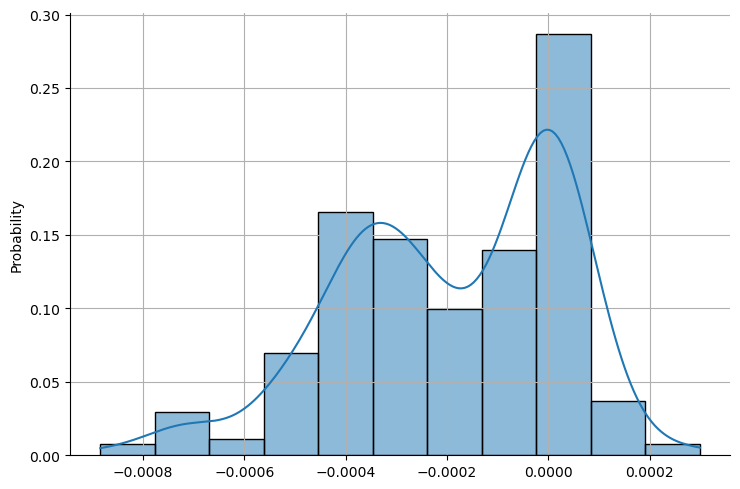

In [25]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_hist_1.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [26]:
def display_scores(scores):
    print('Scores - корни из среднеквадратических ошибок')
    scores = np.sqrt(-scores)
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [27]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-3.0, 0.5]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=-1)

display_scores(scores)

2022-10-07 11:37:36.897335: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-07 11:37:36.897361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-MS-7C80
2022-10-07 11:37:36.897366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-MS-7C80
2022-10-07 11:37:36.897455: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-07 11:37:36.897470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-07 11:37:36.897473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-07 11:37:36.897636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU in

Scores - корни из среднеквадратических ошибок
Scores: [0.00029952 0.00031191 0.00027742 0.00026555 0.00030508]
Mean: 0.0002918956830967281
Standard deviation: 1.7527387394297803e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [28]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00029237709939269624

Оценим ту же метрику на тестовых данных

In [29]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00028274734883848904

Выведем на экран полученный спектр

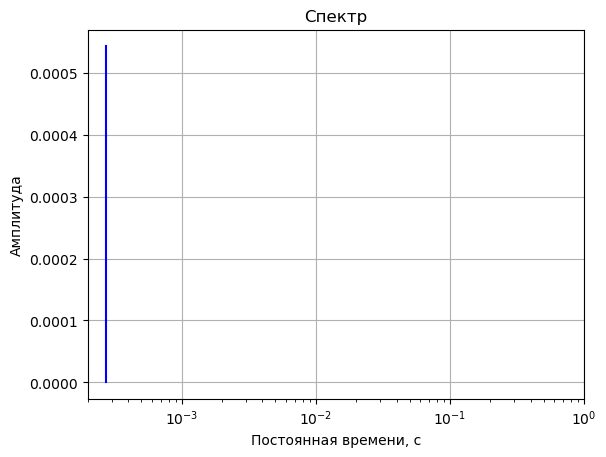

In [30]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/5000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_spectr_1.pdf',
            bbox_inches='tight')
plt.show()

Попробуем идентифицировать модель задав другую начальную точку для идентификации.

Идентификация модели с начальной точкой близкой к отрицательному пику

In [ ]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-1.5, -0.5]])

Приведение результатов к изначальному масштабу

Вывод табличных результатов идентификации

In [ ]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_fit_results_2.csv')
monoexp_fs.fit_results_.tail(10)

Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

In [ ]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_2.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

In [ ]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_loss_2.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_deviations_2.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

In [ ]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_hist_2.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [ ]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-1.5, -0.5]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=-1)

display_scores(np.sqrt(-scores))

Оценим корень из среднеквадратической ошики между экспериментальными данными и данными, полученными на идентифицированной модели

In [ ]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

Выведем на экран полученный спектр

In [ ]:
plot_spectr(monoexp_fs.exps_params_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_spectr_2.pdf',
            bbox_inches='tight')
plt.show()

### 2.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Чтение данных

In [ ]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])

Нормализация данных

In [ ]:
k, y_train = normalize(X_train, y_train)
print(f'Нормализующий коэффицет: {k}')

Идентификация модели

In [ ]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

Приведение результатов к изначальному масштабу

In [ ]:
exps_params_ = monoexp_fs.exps_params_
exps_params_[0, 1] = denormalize(exps_params_[0, 1], k)
monoexp_fs.exps_params_ = exps_params_

fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.amplitude_0 = denormalize(fit_results_.amplitude_0, k) 

y_train = denormalize(y_train, k)

Вывод табличных результатов идентификации

In [ ]:
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

In [ ]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

In [ ]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

In [ ]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [ ]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=-1)

display_scores(np.sqrt(-scores))

Оценим корень из среднеквадратической ошики между экспериментальными данными и данными, полученными на идентифицированной модели

In [ ]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

Выведем на экран полученный спектр

In [ ]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/5000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Чтение данных

In [ ]:
print(data_frames[0][0])

In [ ]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])

Нормализация данных

In [ ]:
k, y_train = normalize(X_train, y_train)
print(f'Нормализующий коэффицет: {k}')

Идентификация мультиэкспоненциальной модели

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [ ]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [ ]:
grid_search.best_params_

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

Для лучшей модели выведем табличные результаты и графики.

Приведение результатов к изначальному масштабу

In [ ]:
multiexp_fs = grid_search.best_estimator_

exps_params_ = multiexp_fs.exps_params_
exps_params_[:, 1] = denormalize(exps_params_[:, 1], k)
multiexp_fs.exps_params_ = exps_params_

fit_results_ = multiexp_fs.fit_results_.copy()

for i in range(multiexp_fs.n_exps):
    fit_results_[f'amplitude_{i}'] = denormalize(fit_results_[f'amplitude_{i}'], k) 

y_train = denormalize(y_train, k)

Вывод табличных результатов идентификации

In [ ]:
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_train)

In [ ]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_model_2.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

In [ ]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, multiexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

In [ ]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [ ]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=-1)

display_scores(np.sqrt(-scores))

Оценим корень из среднеквадратической ошики между экспериментальными данными и данными, полученными на идентифицированной модели

In [ ]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

In [ ]:
filling_pulse, X_train, y_train = get_X_y(data_frames[1][1])

In [ ]:
k, y_train = normalize(X_train, y_train)
k

In [ ]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [ ]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

In [ ]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

In [ ]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

In [ ]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [ ]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True)
plt.grid()
plt.show()

In [ ]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

### 3.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

In [ ]:
multiexp_fs.fit_results_

In [ ]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

In [ ]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

In [ ]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.grid()
plt.show()

In [ ]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=5, kde=True)
plt.show()

In [ ]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

display_scores(np.sqrt(-scores))

In [ ]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [ ]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_train)

In [ ]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)

plt.show()

In [ ]:
grid_search.best_estimator_.fit_results_

In [ ]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=5, kde=True)
plt.show()

In [ ]:
exps_params_283 = grid_search.best_estimator_.exps_params_
exps_params_283[:, 1] = exps_params_283[:, 1] / k

In [ ]:
mean_squared_error(y_train, y_pred, squared=False)

## 4. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_-10С\_-4В-5В\_10мВ\_10мкс\_шаг\_0,01.csv
### 4.1. Подготовка экспериментальных данных

In [ ]:
filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])

In [ ]:
k, y_train = normalize(X_train, y_train)
k

In [ ]:
fig, ax = plot_experimental_points(X_train, y_train)
plt.show()

### 4.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [ ]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

In [ ]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

In [ ]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

In [ ]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [ ]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

### 4.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

In [ ]:
multiexp_fs.fit_results_

In [ ]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

In [ ]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

In [ ]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [ ]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
display_scores(np.sqrt(-scores))

In [ ]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

### 4.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [ ]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_train)

In [ ]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)
plt.show()

In [ ]:
grid_search.best_estimator_.fit_results_

In [ ]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=21, kde=True)
plt.show()

In [ ]:
exps_params_263 = grid_search.best_estimator_.exps_params_
exps_params_263[:, 1] = exps_params_303[:, 1] / k